In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw

In [3]:
import pandas as pd
import numpy as np
import datetime
import os

In [4]:
# Custom functions
from useful_functions import get_inventory_dataset, init_simple_lca, multi_lcia, multi_contribution_analysis, calculate_projected_impacts
from visualisation_functions import plot_multilca_impacts, plot_contribution_analysis, plot_impacts_with_production, plot_incremental_impacts

# Set projects, LCI and LCIA methods

In [5]:
BW_PROJECT = 'regioinvent' # insert your project name here
bd.projects.set_current(BW_PROJECT)
bd.databases

Databases dictionary with 5 object(s):
	Regioinvent
	biosphere3
	biosphere3_spatialized_flows
	ecoinvent-3.9.1-cutoff
	ecoinvent-3.9.1-cutoff regionalized

In [6]:
EI_DB = 'ecoinvent-3.9.1-cutoff regionalized'

In [7]:
biosphere_db = [db for db in bd.databases if 'biosphere' in db.lower()]
biosphere_db

['biosphere3', 'biosphere3_spatialized_flows']

In [8]:
# Filter and display methods that contain "IMPACT World+" in their names
iw_methods = [method for method in bd.methods if "impact world+" in " ".join(method).lower()]
iw_methods

[('IMPACT World+ Damage 2.0.1_regionalized',
  'Ecosystem quality',
  'Climate change, ecosystem quality, long term'),
 ('IMPACT World+ Damage 2.0.1_regionalized',
  'Ecosystem quality',
  'Climate change, ecosystem quality, short term'),
 ('IMPACT World+ Damage 2.0.1_regionalized',
  'Human health',
  'Climate change, human health, long term'),
 ('IMPACT World+ Damage 2.0.1_regionalized',
  'Human health',
  'Climate change, human health, short term'),
 ('IMPACT World+ Midpoint 2.0.1_regionalized',
  'Midpoint',
  'Climate change, long term'),
 ('IMPACT World+ Midpoint 2.0.1_regionalized',
  'Midpoint',
  'Climate change, short term'),
 ('IMPACT World+ Damage 2.0.1_regionalized',
  'Ecosystem quality',
  'Marine acidification, long term'),
 ('IMPACT World+ Damage 2.0.1_regionalized',
  'Ecosystem quality',
  'Marine acidification, short term'),
 ('IMPACT World+ Midpoint 2.0.1_regionalized',
  'Midpoint',
  'Photochemical oxidant formation'),
 ('IMPACT World+ Damage 2.0.1_regionalized'

In [12]:
df_iw_methods = pd.DataFrame(iw_methods, columns=["Method", "Impact Category", "Subcategory"])
#df_iw_methods.to_csv(r'data/iw_methods.csv', index=False)

In [13]:
INVENTORIES_EI = {
    ## Neodymium
    "Neodymium":        ("rare earth oxides production, from rare earth carbonate concentrate", "neodymium oxide", "RoW"),
    
    ## Copper
    "Copper concentrate, Canada": ('copper mine operation and beneficiation, sulfide ore', 'copper concentrate, sulfide ore', 'CA'),
    "Market for copper, cathode": ('market for copper, cathode', 'copper, cathode', 'GLO')
}

In [14]:
# From Istrate et al (2024)
# (name, reference product, location)
INVENTORIES = {
    "Lithium hydroxide, brine":        ("lithium hydroxide production, Salar de Atacama", "lithium hydroxide, battery grade", "CL"),
    "Lithium hydroxide, spodumene":    ("lithium hydroxide production, from Australian spodumene", "lithium hydroxide, battery grade", "CN"),
    "Cobalt":                ("cobalt sulfate production, from copper-cobalt ore, economic allocation", "cobalt sulfate", "CN"),
    "Nickel":                ("nickel sulfate production, average excluding China, economic allocation", "nickel sulfate", "GLO"),
    "Graphite, natural":     ("natural graphite production, battery grade, from Heilongjiang", "natural graphite, battery grade", "CN"),
    "Graphite, synthetic":   ("graphite powder coating", "synthetic graphite, battery grade", "CN"),
    
    "Lithium carbonate, brine":        ("lithium carbonate production, Salar de Atacama", "lithium carbonate, battery grade", "CL"),
    "Lithium carbonate, spodumene":    ("lithium carbonate production, from Australian spodumene", "lithium carbonate, battery grade", "CN"),
}

In [15]:
# Collect data from both the custom database and Ecoinvent database
INVENTORIES_ds = {}
#INVENTORIES_ds.update(get_inventory_dataset(INVENTORIES, LIB_RM_DB))
INVENTORIES_ds.update(get_inventory_dataset(INVENTORIES_EI, EI_DB))

In [16]:
INVENTORIES_ds

{'Neodymium': 'rare earth oxides production, from rare earth carbonate concentrate' (kilogram, RoW, None),
 'Copper concentrate, Canada': 'copper mine operation and beneficiation, sulfide ore' (kilogram, CA, None),
 'Market for copper, cathode': 'market for copper, cathode' (kilogram, GLO, None)}

In [17]:
# Let's take total impacts first
IMPACT_METHODS = {
    "EQ": ('IMPACT World+ Damage 2.0.1_regionalized', 'Ecosystem quality', 'Total ecosystem quality'),
    "HH": ('IMPACT World+ Damage 2.0.1_regionalized', 'Human health', 'Total human health'),
                 }

In [18]:
impact_categories = [
    "Ecosystem quality (PDF.m2.yr)", 
    "Human health (DALYs)", 
]

# Specific impacts

In [19]:
# Initialize LCA object
lca = init_simple_lca(INVENTORIES_ds["Neodymium"], method=IMPACT_METHODS )

In [20]:
specific_lca = {}
for rm in INVENTORIES_ds:
    impacts = multi_lcia(lca, INVENTORIES_ds[rm], IMPACT_METHODS)
    specific_lca[rm] = impacts

specific_lca = pd.DataFrame(specific_lca).T

In [21]:
specific_lca

,EQ (PDF.m2.yr),HH (DALY)
Neodymium,137.644975,0.000162
"Copper concentrate, Canada",11.498468,0.000010
"Market for copper, cathode",45.127553,0.000263


Plot saved to results/lca_impacts_iw_reg.png


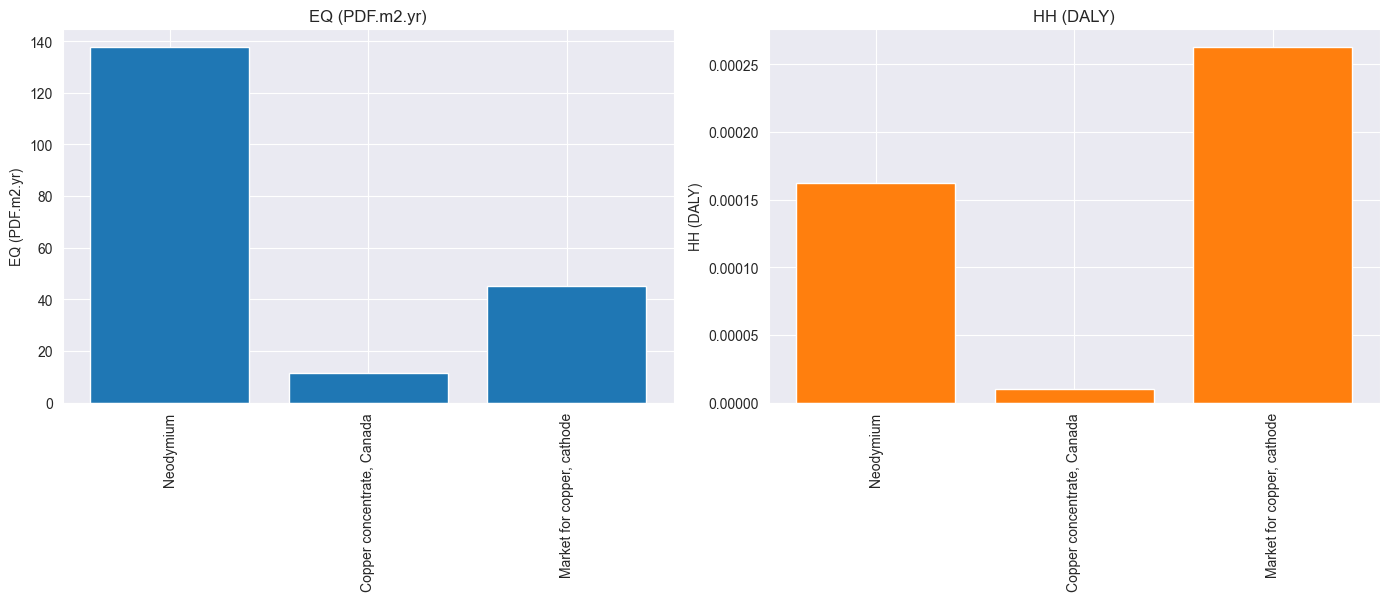

In [24]:
# Call the function
plot_multilca_impacts(specific_lca, 
                 impact_categories =["EQ (PDF.m2.yr)", "HH (DALY)"], 
                 colors=["#1f77b4", "#ff7f0e"], 
                 save_path="results/lca_impacts_iw_reg.png")

In [17]:
#specific_lca.to_csv(f"results/specific_results_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv", index_label="Raw material")

In [25]:
# Initialize a dictionary to store contribution results for each inventory
contribution_results = {}

# Loop through each inventory and perform contribution analysis
for rm_name, rm_ds in INVENTORIES_ds.items():
    lca = init_simple_lca(rm_ds)
    contributions = multi_contribution_analysis(lca, IMPACT_METHODS, top_n=10, threshold=0.01)  # Set your threshold here
    contribution_results[rm_name] = contributions

# Convert the results into a more readable format for analysis
contribution_dfs = {}

for rm_name, impacts in contribution_results.items():
    for impact_name, contributions in impacts.items():
        df = pd.DataFrame(contributions)
        df["Inventory"] = rm_name
        df["Impact Category"] = impact_name
        contribution_dfs[(rm_name, impact_name)] = df

# Combine all individual DataFrames into one for easy viewing
contribution_analysis_df = pd.concat(contribution_dfs.values(), ignore_index=True)

# Set "Inventory" and "Impact Category" as the row indices
contribution_analysis_df.set_index(["Inventory", "Impact Category"], inplace=True)


In [26]:
contribution_analysis_df

score     quantity  \
Inventory                  Impact Category                              
Neodymium                  EQ               3.341805e+01  3528.865095   
                           EQ               1.897885e+01     1.144535   
                           EQ               1.149891e+01     1.205575   
                           EQ               7.269332e+00   806.133520   
                           EQ               5.452072e+00     0.571609   
                           EQ               4.336698e+00     0.261528   
                           EQ               3.130229e+00     2.234295   
                           EQ               2.813017e+00     1.000000   
                           EQ               2.510086e+00     0.015426   
                           HH               1.654619e-04   806.133520   
                           HH               7.944620e-05     1.205575   
                           HH               3.766847e-05     0.571609   
                           HH               2.273334e-05     2.234295   
                           HH               1.658454e-05     4.161896   
                           HH               1.632462e-05     1.000000   
Copper concentrate, Canada EQ               5.589777e+00     0.034353   
                           EQ               2.801620e+00     0.016969   
                           EQ               1.499726e+00   158.367404   
                           EQ               1.260518e-01    90.254200   
                           HH               2.019135e-06     0.010450   
                           HH               7.050246e-07     1.000108   
                           HH               6.610788e-07     0.034353   
                           HH               3.265527e-07     0.016969   
                           HH               3.168971e-07     0.073909   
                           HH               2.277498e-07     0.046554   
                           HH               2.232875e-07     0.000855   
                           HH               2.165953e-07     0.000838   
                           HH               2.081297e-07     0.383445   
                           HH               1.824467e-07     0.014074   
Market for copper, cathode EQ               1.441268e+01     0.088576   
                           EQ               7.345109e+00     0.044489   
                           EQ               4.213765e+00     0.239557   
                           EQ               3.387273e+00     0.028234   
                           EQ               3.121228e+00     0.234890   
                           EQ               2.624244e+00     0.015873   
                           EQ               1.400296e+00   147.867847   
                           EQ               5.374190e-01     3.879929   
                           EQ               4.968756e-01     0.046643   
                           HH               6.257580e-05     0.239557   
                           HH               6.070033e-05     0.234890   
                           HH               4.542084e-05     0.957740   
                           HH               1.230009e-05     0.046643   
                           HH               9.057976e-06     0.028234   
                           HH               8.111455e-06     2.425297   
                           HH               4.652100e-06     0.134229   
                           HH               4.266504e-06     0.018023   
                           HH               3.371692e-06     0.017451   

                                            percentage  \
Inventory                  Impact Category               
Neodymium                  EQ                24.278441   
                           EQ                13.788260   
                           EQ                 8.354036   
                           EQ                 5.281219   
                           EQ                 3.960967   
                           EQ                 3.150640   
         

In [27]:
# Example usage
inventory_names = ["Neodymium"]
colors = ["#1f77b4"]
plot_contribution_analysis(contribution_analysis_df, inventory_names, colors, save_dir="results")

Plot saved to results/contribution_analysis_Neodymium.png


In [21]:
#contribution_analysis_df.to_csv(f"results/contribution_analysis_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv")

# Demand-related impacts

In [22]:
production_existing = pd.read_excel(r'data/scenarios_canadian_climate_institute.xlsx', sheet_name='Production_existing')
production_potential = pd.read_excel(r'data/scenarios_canadian_climate_institute.xlsx', sheet_name='Production_potential')
production_existing = production_existing[production_existing['Scenario']=='Domestic demand scenario']
production_potential = production_potential[production_potential['Scenario']=='Domestic demand scenario']

In [23]:
production_existing['Mineral'].unique()

array(['Cobalt', 'Copper', 'Lithium', 'Nickel', 'Graphite', 'Neodymium'],
      dtype=object)

In [24]:
specific_lca = specific_lca.reset_index().rename(columns={'index': 'Mineral'})
specific_lca

,Mineral,Climate change (kg CO2-Eq),Ecosystem quality (PDF.m2.yr),Human health (DALYs),Water use (m3 world Eq deprived)
0,"Lithium hydroxide, brine",7.670832,0.827068,0.000006,2.078440
1,"Lithium hydroxide, spodumene",17.180445,3.344400,0.000022,2.487335
2,Cobalt,14.927615,3.351673,0.000028,4.524261
3,Nickel,5.460966,6.702595,0.000033,1.033520
4,"Graphite, natural",10.541640,2.119473,0.000009,36.364382
5,"Graphite, synthetic",43.735114,7.392098,0.000033,4.378197
6,"Lithium carbonate, brine",3.610366,0.517874,0.000003,1.869038
7,"Lithium carbonate, spodumene",24.024092,4.659097,0.000031,3.387107
8,Neodymium,55.058910,72.895905,0.000079,36.117563
9,"Copper concentrate, Canada",1.249726,2.174542,0.000003,2.101341


In [25]:
# Define a manual mapping to link the mineral in the scenario with the LCI of our choice
mineral_to_material = {
    "Cobalt": "Cobalt",
    "Copper": "Copper concentrate, Canada",
    "Lithium": "Lithium carbonate, spodumene",
    "Nickel": "Nickel",
    "Graphite": "Graphite, natural",
    "Neodymium": "Copper concentrate, Canada"  
}


In [26]:
# Generate the projected impacts DataFrame
projected_impacts_existing_production = calculate_projected_impacts(production_existing, specific_lca, mineral_to_material)
projected_impacts_potential_production = calculate_projected_impacts(production_potential, specific_lca, mineral_to_material)


In [27]:
projected_impacts_existing_production

,Climate change (kg CO2-Eq),Ecosystem quality (PDF.m2.yr),Human health (DALYs),Water use (m3 world Eq deprived),Year,Mineral
0,6.174211e+07,1.386285e+07,117.461302,1.871280e+07,2018,Cobalt
1,5.124650e+07,1.150629e+07,97.493931,1.553179e+07,2019,Cobalt
2,4.831060e+07,1.084710e+07,91.908520,1.464198e+07,2020,Cobalt
3,5.685417e+07,1.276537e+07,108.162233,1.723136e+07,2021,Cobalt
4,3.785857e+07,8.500322e+06,72.024047,1.147417e+07,2022,Cobalt
...,...,...,...,...,...,...
133,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2036,Neodymium
134,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2037,Neodymium
135,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2038,Neodymium
136,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2039,Neodymium


In [28]:
# Plot impacts per production scenario
plot_impacts_with_production(projected_impacts_existing_production, production_existing, impact_categories, scenario_name='existing_production')
plot_impacts_with_production(projected_impacts_potential_production, production_potential, impact_categories, scenario_name='potential_production')


Combined plot saved to results\combined_impact_existing_production.png
Combined plot saved to results\combined_impact_potential_production.png


In [34]:
# Plot incremental impacts from potential production to existing production
plot_incremental_impacts(projected_impacts_existing_production, projected_impacts_potential_production,
                                 production_existing, production_potential, 
                                 impact_categories, save_dir="results", scenario_name="incremental_comparison")


Incremental impact stacked plot saved to results\incremental_impact_incremental_comparison_stacked.png
